In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pm4py
import scipy
import stormpy
from copy import deepcopy
import numpy as np

In [3]:
from simulation.markov_models import log_parser
from simulation.markov_chain import apply as mc_apply
from simulation.markov_chain_vis import view_markov_chain, view_resource_markov_chain, view_non_resource_markov_chain, view_resource_dfg, view_non_resource_dfg
import simulation.util as sim_util

np.random.seed(42)

# Synthetic event log generation

In [4]:
#TODO: play with different configurations of the log
# ctmc analysis hyper-parameters
epsilon = 1

# Simulation parameters
num_traces = 1000
make_repetitions = False

add_randomness = False

r1_flag = True
go_middle_flag = True


In [5]:
#TODO: change the rate for timings to see how different exponentials behave
rate_for_test = 0.25
#TODO: change the time distributions for the synthetic log from exponential to others
time_sampling_strategies = {0:'exponential',1:'uniform',2:'normal',3:'exp-uni',4:'uni-exp',5:'exp-norm',6:'norm-exp'}
chosen_time_strategy = time_sampling_strategies[0] # values from 0 to 6 can be used here

In [6]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import expon, sem, t, kstest
from datetime import datetime, timedelta

# Simulation parameters
event_labels = ["Acc", "Que", "Com"]

resources = ["Bob","Alice", "Carmen", "Denis", "Ed"]
# Generate synthetic event log
rows = []
for case_id in range(1, num_traces + 1):
    current_time = datetime.now()
    case_id_str = str(case_id)

    rows.append({
        "case:concept:name": case_id_str,
        "concept:name": "Acc",
        "org:role": "Manager",
        "org:resource": "Alice",
        "time:timestamp": current_time
    })
    go_middle = bool(random.getrandbits(1)) if add_randomness else go_middle_flag
    go_middle_flag = not go_middle_flag
    number_of_times = int(random.uniform(1, 5)) if add_randomness else 3
    if not make_repetitions:
        number_of_times = 1
    if go_middle:
        for repetition in range(number_of_times):
            match chosen_time_strategy:
                case 'exponential':
                    current_time += timedelta(hours=np.random.exponential(1 / rate_for_test))
                case 'uniform':
                    current_time += timedelta(hours=random.uniform(2, 6))
                case 'normal':
                    current_time += timedelta(hours=np.random.normal(loc=4, scale=1))
                case 'exp-uni':
                    current_time += timedelta(hours=np.random.exponential(1 / rate_for_test))
                case 'uni-exp':
                    current_time += timedelta(hours=random.uniform(2, 6))
                case 'exp-norm':
                    current_time += timedelta(hours=np.random.exponential(1 / rate_for_test))
                case 'norm-exp':
                    current_time += timedelta(hours=np.random.normal(loc=4, scale=1))
            choose_r1 = bool(random.getrandbits(1)) if add_randomness else r1_flag
            r1_flag = not r1_flag
            rows.append({
                "case:concept:name": case_id_str,
                "concept:name": "Que",
                "org:role": "Manager" if choose_r1 else "Employee",
                "org:resource": f"{resources[random.randint(1, 2)-1]}" if choose_r1 else  f"{resources[random.randint(1, 5)-1]}",
                "time:timestamp": current_time
            })

    match chosen_time_strategy:
        case 'exponential':
            current_time += timedelta(hours=np.random.exponential(1 / rate_for_test))
        case 'uniform':
            current_time += timedelta(hours=random.uniform(2, 6))
        case 'normal':
            current_time += timedelta(hours=np.random.normal(loc=4, scale=1))
        case 'exp-uni':
            current_time += timedelta(hours=random.uniform(2, 6))
        case 'uni-exp':
            current_time += timedelta(hours=np.random.exponential(1 / rate_for_test))
        case 'exp-norm':
            current_time += timedelta(hours=np.random.normal(loc=4, scale=1))
        case 'norm-exp':
            current_time += timedelta(hours=np.random.exponential(1 / rate_for_test))
    rows.append({
        "case:concept:name": case_id_str,
        "concept:name": "Com",
        "org:role": "Employee",
        "org:resource": f"{resources[random.randint(2, 5)-1]}",
        "time:timestamp": current_time
    })

# Create DataFrame
df = pd.DataFrame(rows)
df["time:timestamp"] = pd.to_datetime(df["time:timestamp"])
df = df.sort_values(by=["case:concept:name", "time:timestamp"]).reset_index(drop=True)

final_states = ['Com']

if epsilon>1:
    from simulation.unfold_events import rename_repeating_events
    df, final_states = rename_repeating_events(df,epsilon,final_states)

In [7]:
# Extract time deltas in desired unit
time_diffs = {}
for case_id, group in df.groupby("case:concept:name"):
    events = group["concept:name"].tolist()
    roles = group["org:role"].tolist()
    times = group["time:timestamp"].tolist()
    for i in range(len(events) - 1):
        pair = (events[i], events[i + 1], roles[i+1])
        delta_time = (times[i + 1] - times[i]).total_seconds()/3600
        time_diffs.setdefault(pair, []).append(delta_time)

time_diffs.keys()

dict_keys([('Acc', 'Que', 'Manager'), ('Que', 'Com', 'Employee'), ('Acc', 'Com', 'Employee'), ('Acc', 'Que', 'Employee')])

In [8]:
times_dictionary = time_diffs

In [9]:
true_rates = {}
for k,v in time_diffs.items():
    true_rates[k] = rate_for_test

# Resource allocation models

In [10]:
role_resources = sim_util.get_detailed_weighted_role(df)

In [11]:
role_trials = {k:v for k,v in role_resources.items()}

# Time model: Exponential fit and statistical hypothesis tests

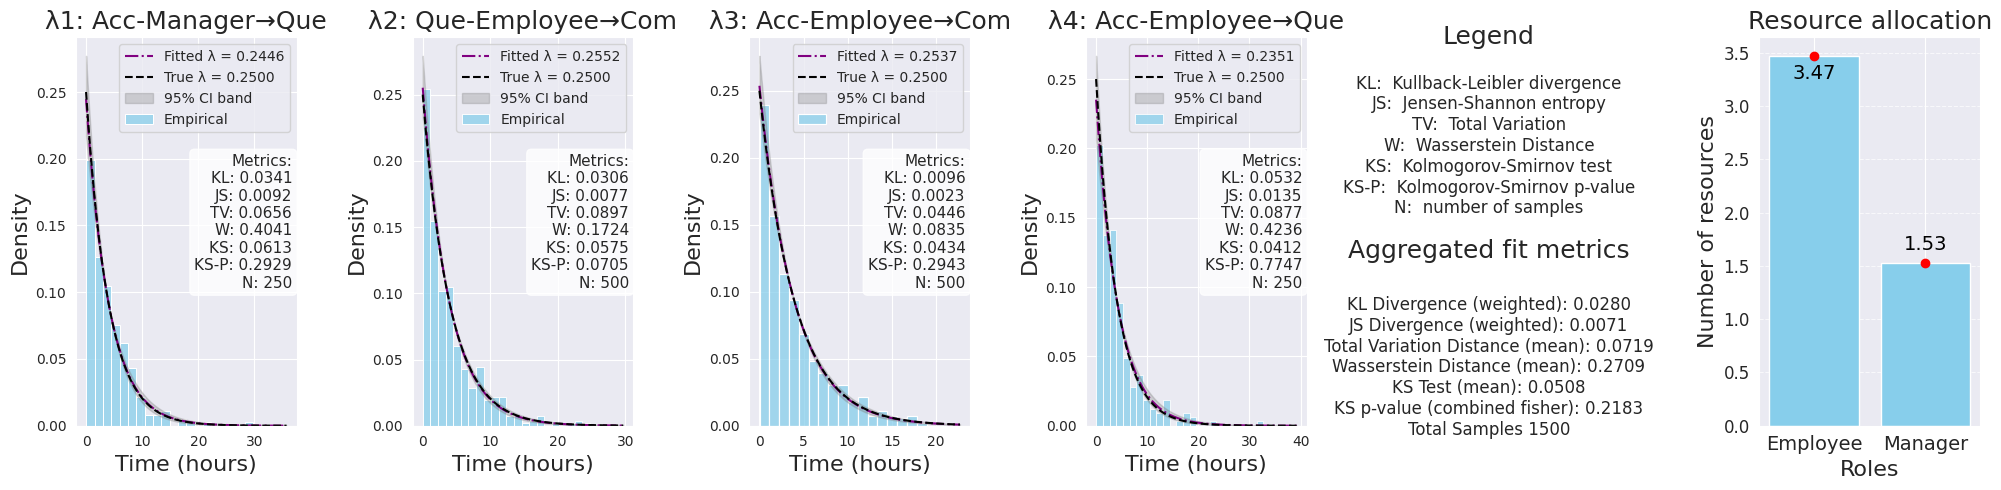

In [12]:
import pandas as pd
from scipy.stats import combine_pvalues
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import expon, sem, t, entropy, kstest
from scipy.special import rel_entr, kl_div
from scipy.stats import wasserstein_distance
from datetime import datetime, timedelta

def compute_freedman_diaconis_bins(data):
    iqr = np.subtract(*np.percentile(data, [75, 25]))
    bin_width = 2 * iqr / (n ** (1/3))
    return int(np.ceil((np.max(data) - np.min(data)) / bin_width)) if bin_width > 0 else 1

# ---- Plot and Compute Distances ----
fig, axes = plt.subplots(1, len(time_diffs)+2, figsize=(20, 5))
metrics_all = {}

data_mean_transition_role_time = {}
tuples_to_discard = set()

i = 1
mean_resource_dfg_times = {}
for ax, (pair, deltas) in zip(axes, time_diffs.items()):
    deltas = np.array(deltas)

    mean_time = deltas.mean() # equivalent to 1/expon.fit(deltas, floc=0)
    mean_resource_dfg_times[pair] = mean_time
    n = len(set(deltas))
    if n > 3:
        loc, scale = expon.fit(deltas) # equivalent to the Fitter fit
        rate = 1/scale
        k,k2,k3 = pair
        if k not in data_mean_transition_role_time:
            data_mean_transition_role_time[k] = {}
        if k2 not in data_mean_transition_role_time[k]:
            data_mean_transition_role_time[k][k2] = {}
        if k3 not in data_mean_transition_role_time[k][k2]:
            data_mean_transition_role_time[k][k2][k3] = {
                'lambda': rate
            }

        # Manual fit
        rate_manual = 1 / mean_time
        ci_half_width = t.ppf(0.975, df=n-1) * sem(deltas)
        lower_rate = 1 / (mean_time + ci_half_width)
        upper_rate = 1 / (mean_time - ci_half_width)

        # True rate
        if true_rates and pair in true_rates:
            rate_true = true_rates[pair]

        # Histogram
        num_bins = compute_freedman_diaconis_bins(deltas)
        counts, bin_edges = np.histogram(deltas, bins=num_bins, density=False)
        bin_widths = np.diff(bin_edges)
        total = np.sum(counts)
        hist_probs = counts / total

        # Model probabilities over bins
        model_probs = expon.cdf(bin_edges[1:], scale=scale) - expon.cdf(bin_edges[:-1], scale=scale)
        # eps = 1e-12
        test_kl_div = entropy(hist_probs, model_probs)
        test2_kl_div = np.sum(kl_div(hist_probs, model_probs))
        ks_test, ks_p_value = kstest(deltas, lambda deltas: expon.cdf(deltas,loc,scale))
        m = 0.5 * (hist_probs + model_probs)
        js_div = 0.5 * (entropy(hist_probs, m) + entropy(model_probs, m))
        tv_dist = 0.5 * np.sum(np.abs(hist_probs - model_probs))
        w_dist = wasserstein_distance(deltas, expon.rvs(scale=scale, size=len(deltas), random_state=42))

        # Save metrics
        metrics_all[pair] = {
            "kl_divergence": test_kl_div,
            "js_divergence": js_div,
            "total_variation": tv_dist,
            "wasserstein_distance": w_dist,
            "ks_test": ks_test,
            "ks_p_value": ks_p_value,
            "n": n
        }

        # Plot histogram and fits
        sns.histplot(deltas, bins=num_bins, stat="density", ax=ax, color="skyblue", label="Empirical")
        x_vals = np.linspace(0, max(deltas) * 1.2, 200)
        ax.plot(x_vals, expon.pdf(x_vals, scale=scale), linestyle="-.", color="purple",
                label=f"Fitted λ = {rate:.4f}")
        if rate_true:
            ax.plot(x_vals, expon.pdf(x_vals, scale=1 / rate_true), linestyle="dashed", color="black",
                    label=f"True λ = {rate_true:.4f}")
        ax.fill_between(x_vals,
                        expon.pdf(x_vals, scale=1 / lower_rate),
                        expon.pdf(x_vals, scale=1 / upper_rate),
                        color="gray", alpha=0.3, label="95% CI band")

        ax.set_title(f"λ{i}: {pair[0]}-{pair[2]}→{pair[1]}",fontsize=18)
        i = i + 1
        ax.set_xlabel(f"Time (hours)",fontsize=16)
        ax.set_ylabel("Density",fontsize=16)
        ax.legend()

        # Text box with metrics
        textstr = 'Metrics:\n'
        textstr += '\n'.join([
            f"KL: {test_kl_div:.4f}",
            f"JS: {js_div:.4f}",
            f"TV: {tv_dist:.4f}",
            f"W: {w_dist:.4f}",
            f"KS: {ks_test:.4f}",
            f"KS-P: {ks_p_value:.4f}",
            f"N: {n}"
        ])
        ax.text(0.98, 0.70, textstr,
                transform=ax.transAxes,
                fontsize=11,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    else:
        print(pair)
        tuples_to_discard.add(pair)

total_n = sum(m["n"] for m in metrics_all.values())

# Weighted averages for divergence metrics
kl_weighted = sum(m["kl_divergence"] * m["n"] for m in metrics_all.values()) / total_n
js_weighted = sum(m["js_divergence"] * m["n"] for m in metrics_all.values()) / total_n

# Simple averages for bounded or scale-sensitive distances
tv_average = np.mean([m["total_variation"] for m in metrics_all.values()])
w_average = np.mean([m["wasserstein_distance"] for m in metrics_all.values()])

ks_average = np.mean([m["ks_test"] for m in metrics_all.values()])
stat, ks_combined_p = combine_pvalues([m["ks_p_value"] for m in metrics_all.values()])
# Final aggregate summary
plot_legend = {
    "KL: ": "Kullback-Leibler divergence",
    "JS: ": "Jensen-Shannon entropy",
    "TV: ": "Total Variation",
    "W: ": "Wasserstein Distance",
    "KS: ": "Kolmogorov-Smirnov test",
    "KS-P: ": "Kolmogorov-Smirnov p-value",
    "N: ": "number of samples"
}
aggregate_metrics_title="Aggregated fit metrics"

aggregate_metrics = {
    "KL Divergence (weighted)": kl_weighted,
    "JS Divergence (weighted)": js_weighted,
    "Total Variation Distance (mean)": tv_average,
    "Wasserstein Distance (mean)": w_average,
    "KS Test (mean)": ks_average,
    "KS p-value (combined fisher)": ks_combined_p,
    "Total Samples": total_n
}

# Print aggregated metrics
# print("\n--- Aggregated Metrics ---")
# for key, val in aggregate_metrics.items():
#     print(f"{key}: {val:.4f}")

# ---- Display stats----
ax_summary = axes[len(axes)-2]
# fig_summary, ax_summary = plt.subplots(figsize=(5, 4))
ax_summary.axis("off")

def format_dict_to_text(input_dict):
    summary_text = '\n'.join([
        f"{k}: {v:.4f}" if isinstance(v, float) else f"{k} {v}"
        for k, v in input_dict.items()
    ])
    return summary_text

ax_summary.text(0.3, 1.1-0.1, "Legend",
                fontsize=18,
                ha="center",
                va="center",
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))
ax_summary.text(0.3, 0.82-0.1, format_dict_to_text(plot_legend),
                fontsize=12,
                ha="center",
                va="center",
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))
ax_summary.text(0.3, 0.55-0.1, aggregate_metrics_title,
                fontsize=18,
                ha="center",
                va="center",
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))
ax_summary.text(0.3, 0.25-0.1, format_dict_to_text(aggregate_metrics),
                fontsize=12,
                ha="center",
                va="center",
                bbox=dict(boxstyle="round", facecolor="white", alpha=1))

# ax_summary.set_title("Legend",fontsize=18)

# ---- Display resource allocations----
ax_hist = axes[len(axes)-1]
# Plot the histogram (bar chart)
# fig, ax = plt.subplots(figsize=(8, 5))
roles = list(role_resources.keys())
values = list(role_resources.values())

# Bar chart
bars = ax_hist.bar(roles, values, color='skyblue')

# Define a top threshold (e.g., 95% of max value for the y-axis)
y_max = max(values) * 1.05  # Increase y-limit for spacing
ax_hist.set_ylim(0, y_max)
threshold = y_max * 0.9

# Add point and value label smartly
for bar, value in zip(bars, values):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    ax_hist.plot(x, y, 'o', color='red')  # Red dot

    # Decide label position
    if y > threshold:
        va = 'top'
        y_offset = -0.08
    else:
        va = 'bottom'
        y_offset = 0.08

    ax_hist.text(x, y + y_offset, f"{value:.2f}", ha='center', va=va, fontsize=14, color='black')

# Labels and grid with increased font size
ax_hist.set_xlabel('Roles', fontsize=16)
ax_hist.set_ylabel('Number of resources', fontsize=16)
ax_hist.tick_params(axis='x', labelsize=14)  # Increase x-axis (role labels) font size
ax_hist.tick_params(axis='y', labelsize=12)  # (Optional) Increase y-axis tick label size
ax_hist.set_title('Resource allocation', fontsize=18)
ax_hist.grid(True, axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.savefig('plots/time-fit.png', format="png")
plt.show()

# Save the plot
# plot_filename = "plots/role-histogram.png"
# plt.tight_layout()
# plt.savefig(plot_filename)
# plt.show()
# plt.close()

In [13]:
total = len(times_dictionary)
kept = len(times_dictionary) - len(tuples_to_discard)
discarded = len(tuples_to_discard)

print('Kept:', kept)
print('Discarded:', discarded)
kept_percent = (kept / total) * 100
print(f'Kept %: {kept_percent:.2f}%')

Kept: 4
Discarded: 0
Kept %: 100.00%


In [14]:
import pm4py
pm4py.write_xes(df, "test.xes")

/home/vco/.pyenv/versions/ctmc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
exporting log, completed traces :: 100%|██████████| 1000/1000 [00:00<00:00, 25160.19it/s]


# Building the ctmc and running it

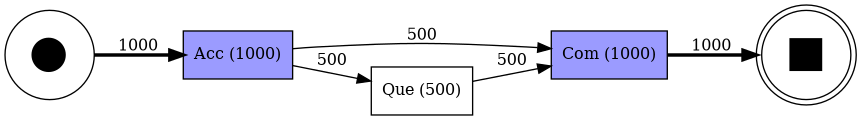

In [15]:
subset_el = pm4py.convert_to_event_log(df)
dfg, start_activities, end_activities = pm4py.discover_dfg(subset_el)
pm4py.view_dfg(dfg, start_activities, end_activities)

In [16]:
subset_el = log_parser.add_start_end(subset_el)
dfg["end", "start"] = 1
subset_el = pm4py.convert_to_dataframe(subset_el)

In [17]:
data_transition_role_frequency = sim_util.get_transition_resource_dict(subset_el)

In [18]:
for (e_from,e_to,role) in tuples_to_discard:
    if e_from in data_transition_role_frequency:
        if e_to in data_transition_role_frequency[e_from]:
            if role in data_transition_role_frequency[e_from][e_to]:
                data_transition_role_frequency[e_from][e_to].pop(role)

In [19]:
for e_from in data_transition_role_frequency.keys():
    for e_to in data_transition_role_frequency.keys():
        if (e_from == 'start' and e_to == 'start') or (e_from == 'end' and e_to == 'end'):
            data_transition_role_frequency[e_from].pop(e_to)

In [20]:
def remove_empty_keys(d):
    """Recursively remove empty keys from a three-level nested dictionary."""
    if not isinstance(d, dict):
        return d  # Return non-dict values as they are

    cleaned_dict = {}
    for key, value in d.items():
        if isinstance(value, dict):
            cleaned_value = remove_empty_keys(value)  # Recursively clean sub-dictionaries
            if cleaned_value:  # Add only if not empty
                cleaned_dict[key] = cleaned_value
        elif value not in (None, "", [], {}, ()):  # Ignore empty values
            cleaned_dict[key] = value

    return cleaned_dict

data_transition_role_frequency = remove_empty_keys(data_transition_role_frequency)

In [21]:
res = {}
dfg_input = {}
out_frequency = {}
data_transition_role_prob = {}
resource_dfg_input = {}

for k,v in data_transition_role_frequency.items():
    if k in ['start','end']:
        continue
    out_freq = 0
    if k not in data_transition_role_prob:
        data_transition_role_prob[k] = {}
        resource_dfg_input[k] = {}

    for k2,v2 in v.items():
        if k2 in ['start','end']:
            continue
        all_freq = 0

        if k2 not in data_transition_role_prob[k]:
            data_transition_role_prob[k][k2] = {}
            resource_dfg_input[k][k2] = {}

        if k not in res:
            res[k] = {}
            dfg_input[k] = {}
        if k2 not in res[k]:
            for k3,v3 in v2.items():
                if k3 not in data_transition_role_prob[k][k2]:
                    data_transition_role_prob[k][k2][k3] = v3
                    resource_dfg_input[k][k2][k3] = v3
                all_freq += v3
            res[k][k2] = all_freq
            dfg_input[k][k2] = all_freq
            out_freq += all_freq
        out_frequency[k] = out_freq
for k,v in res.items():
    for k2,v2 in v.items():
        res[k][k2] = res[k][k2]/out_frequency[k]

for k,v in data_transition_role_prob.items():
    for k2,v2 in v.items():
        for k3,v3 in v2.items():
            data_transition_role_prob[k][k2][k3] = v3/out_frequency[k]

In [22]:
states = set(subset_el['concept:name'].unique()).difference(set(['start','end']))
n = len(states)
i = 0
correspondence = {s:i for s,i in zip(states,range(len(states)))}
#TODO: make sure none of the final states have state = 0 in the prism program
non_final_states = list(states.difference(set(final_states)))
for s in final_states:
    if correspondence[s] == 0:
        correspondence[s] = correspondence[non_final_states[0]]
        correspondence[non_final_states[0]] = 0
correspondence

{'Com': 1, 'Acc': 0, 'Que': 2}

In [23]:
gt_data_mean_transition_role_time = deepcopy(data_mean_transition_role_time)

def replace_lambda_values(d, new_value):
    for key, value in d.items():
        if isinstance(value, dict):
            replace_lambda_values(value, new_value)
        elif key == "lambda":
            d[key] = new_value

replace_lambda_values(gt_data_mean_transition_role_time,0.25)

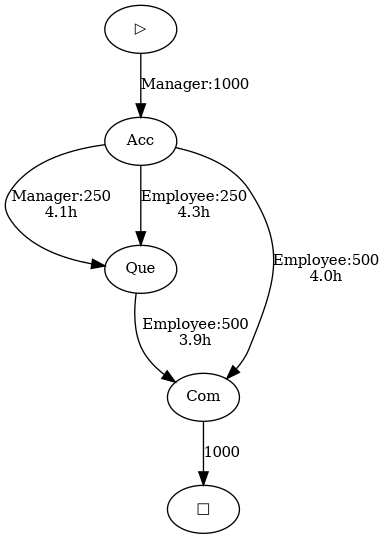

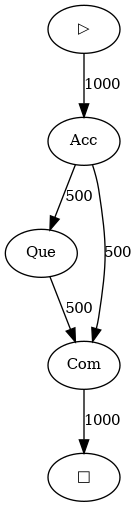

In [24]:
start_states = ['Acc']
end_states = ['Com']
if epsilon!=1:
    start_states = ['Acc1']
    end_states = ['Com1']
view_resource_dfg(resource_dfg_input,mean_times=mean_resource_dfg_times,start_states=start_states, end_states=end_states,percentage=False)
view_non_resource_dfg(dfg_input,start_states=start_states, end_states=end_states,percentage=False)

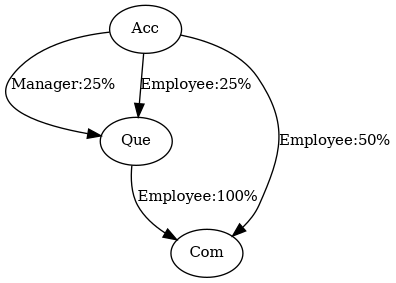

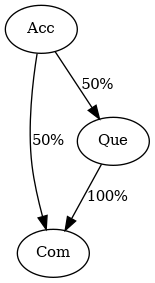

In [25]:
view_resource_markov_chain(data_transition_role_prob,percentage=True)
view_non_resource_markov_chain(res,percentage=True)

In [26]:
data_transition_role_frequency

{'start': {'Acc': {'Manager': 1000}},
 'Acc': {'Que': {'Manager': 250, 'Employee': 250}, 'Com': {'Employee': 500}},
 'Que': {'Com': {'Employee': 500}},
 'Com': {'end': {'Employee': 1000}}}

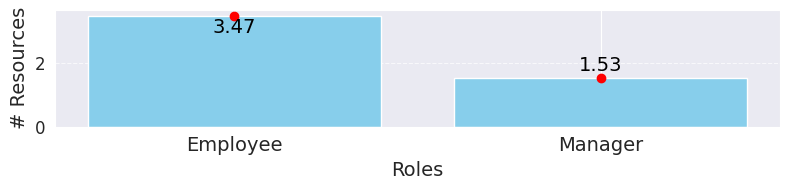

In [27]:
def plot_resources(organizational_roles,save=False):
    # Plot the histogram (bar chart)
    fig, ax = plt.subplots(figsize=(8, 2))
    roles = list(organizational_roles.keys())
    values = list(organizational_roles.values())

    # Bar chart
    bars = ax.bar(roles, values, color='skyblue')

    # Define a top threshold (e.g., 95% of max value for the y-axis)
    y_max = max(values) * 1.05  # Increase y-limit for spacing
    ax.set_ylim(0, y_max)
    threshold = y_max * 0.9

    # Add point and value label smartly
    for bar, value in zip(bars, values):
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        ax.plot(x, y, 'o', color='red')  # Red dot

        # Decide label position
        if y > threshold:
            va = 'top'
            y_offset = -0.08
        else:
            va = 'bottom'
            y_offset = 0.08

        ax.text(x, y + y_offset, f"{value:.2f}", ha='center', va=va, fontsize=14, color='black')

    # Labels and grid with increased font size
    ax.set_xlabel('Roles', fontsize=14)
    ax.set_ylabel('# Resources', fontsize=14)
    ax.tick_params(axis='x', labelsize=14)  # Increase x-axis (role labels) font size
    ax.tick_params(axis='y', labelsize=12)  # (Optional) Increase y-axis tick label size
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    # Save the plot
    if save:
        plot_filename = "plots/syntheticroles.png"
        plt.savefig(plot_filename)
    plt.show()
    plt.close()

plot_resources(role_resources)

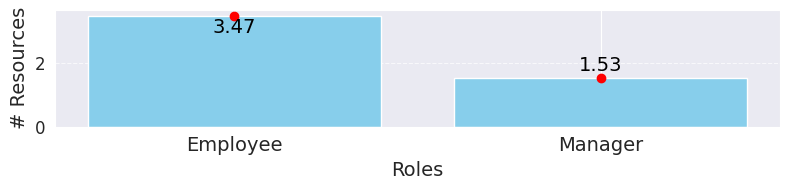

In [28]:
#TODO: Play with the role trials, by for example uncommenting the line below to make A2 = 200
# role_trials['A2'] = 200
plot_resources(role_trials)
for k, v in role_trials.items():
    if v<=0:
        raise ValueError('Cannot have 0 or negative number of resources !')

In [29]:
from simulation.ctmc_frequency import create_prism_program_from_log

probabilities = create_prism_program_from_log(
                            correspondence,
                            final_states,
                            data_mean_transition_role_time,
                            role_resources,
                            data_transition_role_frequency,
                            role_trials,
                            'ctmc.sm',
                            show_print=True)

gt_probabilities = create_prism_program_from_log(
                            correspondence,
                            final_states,
                            gt_data_mean_transition_role_time,
                            role_resources,
                            data_transition_role_frequency,
                            role_trials,
                            'ctmc-gt.sm')

local {'Com': {'Com': 1, 'Acc': 1, 'Que': 1}, 'Acc': {'Com': 500, 'Acc': 1, 'Que': 500}, 'Que': {'Com': 500, 'Acc': 1, 'Que': 1}}
total {'Com': 1, 'Acc': 1000, 'Que': 500}
final probabilities {'Acc': {'Que': 0.5, 'Com': 0.5}, 'Que': {'Com': 1.0}, 'Com': {}}


In [36]:
prism_program = stormpy.parse_prism_program('ctmc.sm',prism_compat=True,simplify=True)
gt_prism_program = stormpy.parse_prism_program('ctmc-gt.sm',prism_compat=True,simplify=True)
model = stormpy.build_model(prism_program)
gt_model = stormpy.build_model(gt_prism_program)

def get_result(model, prism_program):
    labels = ""
    for fs in final_states:
        labels += f'"q_terminal_{fs}" |'
    labels = labels[:-2]
    formula_str = f'Tmin=? [F {labels}]'
    print(formula_str)
    properties = stormpy.parse_properties(formula_str, prism_program)
    result = stormpy.model_checking(model, properties[0])
    initial_state = model.initial_states[0]
    result = result.at(initial_state)
    print(f"Hours: {result}")
    if result<np.inf:
        print(f"Duration: {timedelta(hours=result)}")
    return result

print('Mined timings:')
result = get_result(model,prism_program)
print('Fixed Ground Truth exponential at 0.25:')
gt_result = get_result(gt_model,gt_prism_program)

Mined timings:
Tmin=? [F "q_terminal_Com"]
Hours: 5.956039897894462
Duration: 5:57:21.743632
Fixed Ground Truth exponential at 0.25:
Tmin=? [F "q_terminal_Com"]
Hours: 6.0
Duration: 6:00:00


Difference between ground truth rate calculation and fitted exponential calculation

In [31]:
abs(result - gt_result)

0.04396010210553758

# Resource Regression Analysis

In [32]:
import random

durations = []
# x = list(range(1,50))
samples = 500
for i in range(samples):
    regression_role_trials = {}
    for k,v in role_trials.items():
        # random_resource_number = abs(random.gauss(v,v/2))
        random_resource_number = abs(random.uniform(v/2,v**2))
        regression_role_trials[k] = random_resource_number
    probabilities = create_prism_program_from_log(
                            correspondence,
                            final_states,
                            data_mean_transition_role_time,
                            role_resources,
                            data_transition_role_frequency,
                            regression_role_trials,
                            'ctmc-temp.sm')
    prism_program = stormpy.parse_prism_program('ctmc-temp.sm', prism_compat=True, simplify=True)
    model = stormpy.build_model(prism_program)
    labels = ""
    for fs in final_states:
        labels += f'"q_terminal_{fs}" |'
    labels = labels[:-2]

    formula_str = f'Tmin=? [F {labels}]'
    properties = stormpy.parse_properties(formula_str, prism_program)
    result = stormpy.model_checking(model, properties[0])
    initial_state = model.initial_states[0]
    result = result.at(initial_state)
    durations.append({**regression_role_trials, "duration": result})
    # print(f'{i}/{samples}')

In [33]:
durations_df = pd.DataFrame(durations)
durations_df

,Employee,Manager,duration
0,4.014002,2.194395,5.051359
1,9.035639,1.635954,2.421992
2,11.193849,2.247772,1.945520
3,5.486540,2.100989,3.811475
4,10.860052,0.783806,2.074061
...,...,...,...
495,7.836555,1.302118,2.803062
496,5.657480,1.814585,3.744803
497,2.333367,1.493324,8.554626
498,11.665075,1.092812,1.919424


In [34]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Example: Load your DataFrame
# df = pd.read_csv("your_data.csv")

def run_linear_regression(df, target_column, fit_intercept=True):
    # Split into X (features) and y (target)
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Fit model
    model = LinearRegression(fit_intercept=fit_intercept)
    model.fit(X, y)

    # Print model coefficients
    intercept = model.intercept_
    coef = model.coef_

    print("Intercept:", intercept if fit_intercept else "Not used")
    print("Coefficients:")
    for col, weight in zip(X.columns, coef):
        print(f"{col}: {weight:.4f}")

    return model, X.columns, coef

def rank_features_by_importance(X, coef):
    importance_df = pd.DataFrame({
        'Feature': X,
        'Coefficient': coef,
        'Importance (abs)': abs(coef)
    })
    return importance_df.sort_values(by='Importance (abs)', ascending=False)

# Run regression
model, features, coefs = run_linear_regression(durations_df, 'duration', fit_intercept=True)

# Rank features
ranking = rank_features_by_importance(features, coefs)
print("\nFeature Ranking:\n", ranking)

Intercept: 8.96189553493046
Coefficients:
Employee: -0.6693
Manager: -0.2182

Feature Ranking:
     Feature  Coefficient  Importance (abs)
0  Employee    -0.669310          0.669310
1   Manager    -0.218183          0.218183


# pm4py

In [35]:
mean, median, margin_of_error = sim_util.get_pm4py_reference_times(subset_el)
print(timedelta(seconds=median))
print(timedelta(seconds=mean))
print(timedelta(seconds=margin_of_error))

4:38:15.312616
6:03:02.914289
0:20:19.265036
